In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# albumentation library
import albumentations as A

# radiomics library 
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)

print(os.listdir("../Datasets/input_segmentation"))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata', 'HAM10000_segmentations_lesion_tschandl']


In [2]:
data_dir = '../Datasets/input_segmentation'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
all_masks_path = glob(os.path.join(data_dir, '*', '*.png'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
maskid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_masks_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata'))
df_original.insert(2, 'mask_id', df_original['image_id'].astype(str) + '_segmentation')
df_original['image_path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['mask_path'] = df_original['mask_id'].map(maskid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

lesion_id      image_id                    mask_id   dx dx_type   age  \
0  HAM_0000118  ISIC_0027419  ISIC_0027419_segmentation  bkl   histo  80.0   
1  HAM_0000118  ISIC_0025030  ISIC_0025030_segmentation  bkl   histo  80.0   
2  HAM_0002730  ISIC_0026769  ISIC_0026769_segmentation  bkl   histo  80.0   
3  HAM_0002730  ISIC_0025661  ISIC_0025661_segmentation  bkl   histo  80.0   
4  HAM_0001466  ISIC_0031633  ISIC_0031633_segmentation  bkl   histo  75.0   

    sex localization       dataset  \
0  male        scalp  vidir_modern   
1  male        scalp  vidir_modern   
2  male        scalp  vidir_modern   
3  male        scalp  vidir_modern   
4  male          ear  vidir_modern   

                                          image_path  \
0  ../Datasets/input_segmentation\HAM10000_images...   
1  ../Datasets/input_segmentation\HAM10000_images...   
2  ../Datasets/input_segmentation\HAM10000_images...   
3  ../Datasets/input_segmentation\HAM10000_images...   
4  ../Datasets/input_segmentation\HAM10000_images...   

                                           mask_path  \
0  ../Datasets/input_segmentation\HAM10000_segmen...   
1  ../Datasets/input_segmentation\HAM10000_segmen...   
2  ../Datasets/input_segmentation\HAM10000_segmen...   
3  ../Datasets/input_segmentation\HAM10000_segmen...   
4  ../Datasets/input_segmentation\HAM10000_segmen...   

                       cell_type  cell_type_idx  
0  Benign keratosis-like lesions              2  
1  Benign keratosis-like lesions              2  
2  Benign keratosis-like lesions              2  
3  Benign keratosis-like lesions              2  
4  Benign keratosis-like lesions              2

In [4]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

lesion_id  image_id  mask_id  dx  dx_type  age  sex  localization  \
0  HAM_0000001         1        1   1        1    1    1             1   
1  HAM_0000003         1        1   1        1    1    1             1   
2  HAM_0000004         1        1   1        1    1    1             1   
3  HAM_0000007         1        1   1        1    1    1             1   
4  HAM_0000008         1        1   1        1    1    1             1   

   dataset  image_path  mask_path  cell_type  cell_type_idx  
0        1           1          1          1              1  
1        1           1          1          1              1  
2        1           1          1          1              1  
3        1           1          1          1              1  
4        1           1          1          1              1

In [5]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

lesion_id      image_id                    mask_id   dx dx_type   age  \
0  HAM_0000118  ISIC_0027419  ISIC_0027419_segmentation  bkl   histo  80.0   
1  HAM_0000118  ISIC_0025030  ISIC_0025030_segmentation  bkl   histo  80.0   
2  HAM_0002730  ISIC_0026769  ISIC_0026769_segmentation  bkl   histo  80.0   
3  HAM_0002730  ISIC_0025661  ISIC_0025661_segmentation  bkl   histo  80.0   
4  HAM_0001466  ISIC_0031633  ISIC_0031633_segmentation  bkl   histo  75.0   

    sex localization       dataset  \
0  male        scalp  vidir_modern   
1  male        scalp  vidir_modern   
2  male        scalp  vidir_modern   
3  male        scalp  vidir_modern   
4  male          ear  vidir_modern   

                                          image_path  \
0  ../Datasets/input_segmentation\HAM10000_images...   
1  ../Datasets/input_segmentation\HAM10000_images...   
2  ../Datasets/input_segmentation\HAM10000_images...   
3  ../Datasets/input_segmentation\HAM10000_images...   
4  ../Datasets/input_segmentation\HAM10000_images...   

                                           mask_path  \
0  ../Datasets/input_segmentation\HAM10000_segmen...   
1  ../Datasets/input_segmentation\HAM10000_segmen...   
2  ../Datasets/input_segmentation\HAM10000_segmen...   
3  ../Datasets/input_segmentation\HAM10000_segmen...   
4  ../Datasets/input_segmentation\HAM10000_segmen...   

                       cell_type  cell_type_idx  duplicates  
0  Benign keratosis-like lesions              2  duplicated  
1  Benign keratosis-like lesions              2  duplicated  
2  Benign keratosis-like lesions              2  duplicated  
3  Benign keratosis-like lesions              2  duplicated  
4  Benign keratosis-like lesions              2  duplicated

In [6]:
df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [7]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 14)

In [8]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 14)

In [9]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
5     46
1     35
0     30
6     13
3      8
Name: count, dtype: int64

In [10]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [11]:
df_train['cell_type_idx'].value_counts()

cell_type_idx
4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: count, dtype: int64

In [12]:
df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                 883
Benign keratosis-like lesions     88
Melanoma                          46
Basal cell carcinoma              35
Actinic keratoses                 30
Vascular lesions                  13
Dermatofibroma                     8
Name: count, dtype: int64

In [13]:
data_aug_rate = [18, 12, 5, 50, 0, 5, 40]
dfs_to_concat = []

for i in range(7):
    if data_aug_rate[i]:
        subset = df_train.loc[df_train['cell_type_idx'] == i, :]
        duplicated_subset = [subset] * (data_aug_rate[i] - 1)
        dfs_to_concat.extend(duplicated_subset)

df_train = pd.concat([df_train] + dfs_to_concat, ignore_index=True)
df_train['cell_type'].value_counts()

cell_type
Melanocytic nevi                 5822
Basal cell carcinoma             5748
Dermatofibroma                   5350
Actinic keratoses                5346
Melanoma                         5335
Vascular lesions                 5160
Benign keratosis-like lesions    5055
Name: count, dtype: int64

In [14]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()


In [15]:
# define the transformation of the train images.
transforms = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
                        A.ColorJitter(p=0.2, brightness=0.1, contrast=0.1, hue=0.1),
                        A.Rotate(limit=20, p=5.0), A.GaussNoise(var_limit=(10.0, 50.0), p=0.2)], is_check_shapes=False, additional_targets={})

transform = A.Compose([A.Resize(256, 256)], is_check_shapes=False)


In [16]:
#saasdasd = A.Compose([ A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)], is_check_shapes=False)
saasdasd = A.Compose([ A.HorizontalFlip(p=1.0)], is_check_shapes=False)
#saasdasd = A.Compose([ A.ColorJitter(var_limit=(10.0, 50.0), p=1.0)], is_check_shapes=False)
#saasdasd = A.Compose([ A.Rotate(limit=20, p=1.0)], is_check_shapes=False)
#saasdasd = A.Compose([ A.VerticalFlip(p=1.0)], is_check_shapes=False)


In [17]:
X = cv2.imread(df_train['image_path'][0])
X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
y = cv2.imread(df_train['mask_path'][0], 0)

transformssss = saasdasd(image=X, mask=y)
X_t = transformssss['image']
y_t = transformssss['mask']

In [18]:
def color_extraction(img):
    b, g, r = cv2.split(img)
    mean_b, std_b = cv2.meanStdDev(b)
    mean_g, std_g = cv2.meanStdDev(g)
    mean_r, std_r = cv2.meanStdDev(r)
    return {"mean_b": mean_b, "std_b": std_b, "mean_g": mean_g, "std_g": std_g, "mean_r": mean_r, "std_r": std_r}


In [19]:
def augmentation(df, index, transform):
    # Load data and get label
    X = cv2.imread(df['image_path'][index])
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    y = cv2.imread(df['mask_path'][index], 0)


    #transformed = transform(image=X, mask=y)
    #X = transformed['image']
    #y = transformed['mask']

    X_rad = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)

    X_rad = sitk.GetImageFromArray(X_rad)
    y_rad = sitk.GetImageFromArray(y)

    return X, y, X_rad, y_rad

In [20]:
# USAGE
def prepare_plot(origImage, augImage, origMask, augMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(augImage)
    ax[2].imshow(origMask)
    ax[3].imshow(augMask)
    # set the titles of the subplots
    ax[0].set_title("Original Image")
    ax[1].set_title("Augmented Image")
    ax[2].set_title("Original Mask")
    ax[3].set_title("Augmented Mask")
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()
    

C:\Users\Krystian\AppData\Local\Temp\ipykernel_13188\3639772788.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


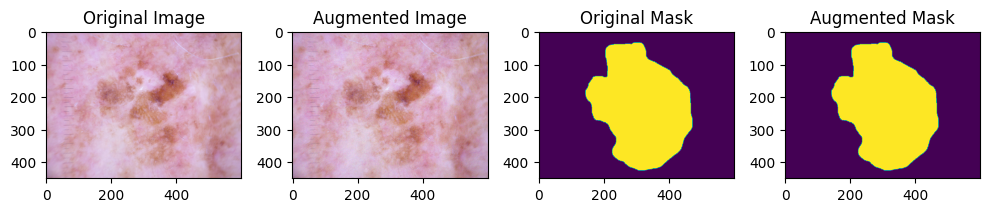

In [21]:
prepare_plot(X, X_t, y, y_t)

In [22]:
params = 'params.yaml'

In [23]:
extractor = featureextractor.RadiomicsFeatureExtractor(params)
results = []
#results_colors = []

for i in range(len(df_train)):
    X, y, X_rad, y_rad = augmentation(df_train, i, transforms)

    # Expand dimensions of mask array
    #label = np.expand_dims(y, axis=2)
    #newmask = np.concatenate((label, label, label), axis=2)
    
    # Multiply new mask with image
    #cob = X * newmask
    #original = original.squeeze()
    #original.save("original.png")

    result = extractor.execute(X_rad, y_rad)
    results.append(result)
    #result_color = color_extraction(cob)
    #results_colors.append(result_color)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [24]:
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results[0] )))
#feature_names_colors = list(sorted(filter ( lambda k: k.startswith(""), results_colors[0] )))

In [25]:
def get_samples(df, feature_names, results):
    samples = np.zeros((len(df),len(feature_names)))
    for case_id in range(0 ,len(df)):
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, results[case_id][feature_name])
        samples[case_id,:] = a
    # May have NaNs
    samples = np.nan_to_num(samples)
    return samples


In [26]:
samples = get_samples(df_train, feature_names, results)
#samples_colors = get_samples(df_val, feature_names_colors, results_colors)


In [27]:
column_names = feature_names
#column_names_colors = feature_names_colors

features_df = pd.DataFrame(samples)
features_df.columns = feature_names

#features_df_colors = pd.DataFrame(samples_colors)
#features_df_colors.columns = feature_names_colors

In [28]:
categories_df = pd.DataFrame()
mapping = {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 
           'Benign keratosis-like lesions': 2, 'Dermatofibroma': 3,
           'Melanocytic nevi': 4, 'Vascular lesions': 5, 'Melanoma':6}
categories_df['category'] = df_train['cell_type'].replace(mapping)


In [29]:
df  = pd.concat([features_df, categories_df], axis=1)
#df  = pd.concat([features_df, features_df_colors, categories_df], axis=1)

In [30]:
df



original_firstorder_10Percentile  original_firstorder_90Percentile  \
0                                 143.0                             198.0   
1                                 147.0                             208.0   
2                                 152.0                             194.0   
3                                 147.0                             194.0   
4                                 110.0                             185.0   
...                                 ...                               ...   
37811                             107.0                             167.0   
37812                              73.0                             144.0   
37813                              88.0                             156.0   
37814                              87.0                             152.0   
37815                             120.0                             179.0   

       original_firstorder_Energy  original_firstorder_Entropy  \
0                    2.630443e+09                     1.862375   
1                    1.078528e+09                     1.977254   
2                    2.229799e+09                     1.563598   
3                    6.341172e+08                     1.712056   
4                    2.337326e+09                     2.258596   
...                           ...                          ...   
37811                2.972462e+08                     1.881432   
37812                3.083428e+08                     2.022091   
37813                2.160541e+08                     1.947813   
37814                2.211682e+08                     1.830523   
37815                2.849747e+09                     1.903163   

       original_firstorder_InterquartileRange  original_firstorder_Kurtosis  \
0                                        28.0                      4.006015   
1                                        31.0                      3.845682   
2                                        21.0                      4.874394   
3                                        24.0                      4.449693   
4                                        41.0                      2.581706   
...                                       ...                           ...   
37811                                    34.0                      2.378760   
37812                                    40.0                      2.375259   
37813                                    41.0                      2.143251   
37814                                    41.0                      2.088375   
37815                                    29.0                      2.871116   

       original_firstorder_Maximum  original_firstorder_Mean  \
0                            243.0                174.132188   
1                            246.0                181.065860   
2                            241.0                174.972768   
3                            241.0                171.030542   
4                            244.0                147.995181   
...                            ...                       ...   
37811                        193.0                131.945969   
37812                        193.0                100.365479   
37813                        188.0                116.505692   
37814                        169.0                111.767156   
37815                        210.0                143.474604   

       original_firstorder_MeanAbsoluteDeviation  original_firstorder_Median  \
0                                      17.417523                       178.0   
1                                      18.852686                       185.0   
2                                      13.333674                       177.0   
3                                      14.712894                       173.0   
4                                      23.050400                       148.0   
...                                          ...                         ...   
37811      

In [31]:
df.to_csv('../Datasets/begginingaftertheend.csv')